In [1]:
#Libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

#MI (see below 6th cell for explanation)
from sklearn.feature_selection import mutual_info_classif

#RFECV is a wrapper feature selection approach that fits a learning model and eliminates the less important features using cross-validation.
#From the score obtained by the MI classifier, the features are ranked and eliminated recursively based on the iterations.
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

#For the cross-validation
from sklearn.model_selection import StratifiedKFold


from sklearn.neighbors import KernelDensity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Load the dataset
df = pd.read_csv('Modified_Collisions.csv')
df['INCDATE'] = pd.to_datetime(df['INCDATE'])
df['Month'] = df['INCDATE'].dt.month

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

df['Season'] = df['Month'].map(season_mapping)

df['Weekday'] = df['INCDATE'].dt.dayofweek

In [3]:
# Step 1: Remove rows with SEVERITYCODE = 0
df = df[df['SEVERITYCODE'] != 0]

# Step 2: Merge severe injury (2b) and fatal (3) categories into a single category labeled "3"
df['SEVERITYCODE'] = df['SEVERITYCODE'].replace({2.5: 3})

# Step 3: Remove columns with more than 10% missing values
threshold = len(df) * 0.9  # Keep columns with at least 90% non-missing values
columns_to_keep = df.columns[df.notnull().sum() >= threshold]
df = df[columns_to_keep]

# Step 4: Remove descriptive or non-predictive columns
non_predictive_columns = [
    'X', 'Y', 'INCKEY', 'COLDETKEY',
    'OBJECTID', 'REPORTNO', 'INCDATE', 'INCDTTM', 'LOCATION',
    'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS', 'SDOT_COLDESC',
    'ST_COLDESC', 'INTKEY', 'SEVERITYDESC'
]
df = df.drop(columns=non_predictive_columns, errors='ignore')

# Step 5: One-hot encode categorical variables (WEATHER, ROADCOND, LIGHTCOND)
categorical_columns = ['WEATHER', 'ROADCOND', 'LIGHTCOND']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df = df.dropna()

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['ADDRTYPE'] = label_encoder.fit_transform(df['ADDRTYPE'])
df['COLLISIONTYPE'] = label_encoder.fit_transform(df['COLLISIONTYPE'])
df['JUNCTIONTYPE'] = label_encoder.fit_transform(df['JUNCTIONTYPE'])
df['HITPARKEDCAR'] = label_encoder.fit_transform(df['HITPARKEDCAR'])
df['Season'] = label_encoder.fit_transform(df['Season'])


In [5]:
pd.set_option('display.max_columns', None)
df

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,High_Risk_Driver,Environmental_Risk,Month,Season,Weekday,WEATHER_Blowing Snow,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Other,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,WEATHER_Severe Crosswind,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Snowing,WEATHER_Unknown,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,2,2.0,6,2,1,0,1,1,0,0,1,24.0,0,0,0,2,0,0,0,0,3.0,11,0,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,2,2.0,0,4,0,0,2,2,0,0,1,11.0,0,0,0,10,0,0,0,0,9.0,11,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
2,1,1.0,9,4,0,0,3,0,0,0,4,14.0,0,0,0,11,0,0,0,0,3.0,2,3,3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,2,1.0,3,2,0,0,2,0,0,0,1,11.0,0,0,0,28,0,0,0,0,9.0,6,2,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
6,1,1.0,4,2,0,0,2,0,0,0,4,28.0,0,0,0,50,0,0,0,0,6.0,6,2,6,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221261,1,1.0,7,2,0,0,2,0,0,0,4,14.0,0,0,0,14,0,0,0,0,3.0,3,1,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
221262,1,2.0,7,2,0,0,2,1,0,0,4,14.0,0,0,0,14,0,0,0,0,3.0,4,1,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
221263,2,1.0,8,2,0,0,2,0,0,0,1,11.0,0,0,0,16,0,0,0,0,3.0,5,1,3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
221264,1,1.0,0,3,0,0,2,0,0,0,2,11.0,0,0,0,10,0,0,0,0,3.0,6,2,5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


DATA IS READY FOR PROCESSING

In [6]:
X = df.drop(columns=["SEVERITYCODE", "FATALITIES", "INJURIES", "SERIOUSINJURIES"])
y = df["SEVERITYCODE"]


In [7]:
mi_scores = mutual_info_classif(X, y)
mi_scores_sorted = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)

In [8]:
top_features_mi = [feature for feature, score in mi_scores_sorted[:] if score > 0.002]
X_mi_selected = X[top_features_mi]
X_mi_selected


,ST_COLCODE,COLLISIONTYPE,SDOT_COLCODE,VEHCOUNT,PEDCOUNT,ADDRTYPE,JUNCTIONTYPE,LIGHTCOND_Daylight,PERSONCOUNT,PEDCYLCOUNT,WEATHER_Clear,CROSSWALKKEY,ROADCOND_Unknown,WEATHER_Unknown,LIGHTCOND_Unknown,SEGLANEKEY,Environmental_Risk,High_Risk_Driver,LIGHTCOND_Dark - Street Lights On,HITPARKEDCAR,Weekday,ROADCOND_Wet,Season,UNDERINFL,WEATHER_Raining,SPEEDING
0,2,6,24.0,1,1,2,1,True,2,0,True,0,False,False,False,0,3.0,0,False,0,2,False,0,0,False,0
1,10,0,11.0,2,0,2,1,False,4,0,False,0,False,False,False,0,9.0,0,True,0,0,True,0,0,True,0
2,11,9,14.0,3,0,1,4,True,4,0,True,0,False,False,False,0,3.0,0,False,0,3,False,3,0,False,0
3,28,3,11.0,2,0,2,1,False,2,0,False,0,False,False,False,0,9.0,0,True,0,1,True,2,0,True,0
6,50,4,28.0,2,0,1,4,False,2,0,True,0,False,False,False,0,6.0,0,True,0,6,False,2,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221261,14,7,14.0,2,0,1,4,True,2,0,False,0,True,True,False,0,3.0,0,False,0,3,False,1,0,False,0
221262,14,7,14.0,2,0,1,4,True,2,0,True,0,False,False,False,0,3.0,0,False,0,4,False,1,0,False,0
221263,16,8,11.0,2,0,2,1,True,2,0,True,0,False,False,False,0,3.0,0,False,0,3,False,1,0,False,0
221264,10,0,11.0,2,0,1,2,True,3,0,True,0,False,False,False,0,3.0,0,False,0,5,False,2,0,False,0


In [9]:
y = label_encoder.fit_transform(y)

In [10]:
#Define XGBoost model (RFE needs an estimator and the research paper used an XGB model)
#The scale_pos_weight parameter in the XGBClassifier is used to handle class imbalance by adjusting the weighting of positive and negative classes during training.
#It ensures that the model pays appropriate attention to the minority class (e.g., fraudulent transactions) in highly imbalanced datasets like credit card fraud detection.
#Without weighting, the model may predict the majority class (0, non-fraudulent) overwhelmingly, leading to poor recall for the minority class.
#scale_pos_weight adjusts the balance by increasing the penalty for misclassifying the minority class.
xgb = XGBClassifier(random_state=42)

#Recursive Feature Elimination with Cross-Validation
#From the MI feature ranking, the best predictors are selected for the next stage of processing by RFE with crossvalidation. 
#The best feature subset identified from the first phase is given as the input for the second phase to filter the features with high relevance and correlation.
#The RFE method eliminates the less important features recursively for each iteration based on the decision scores returned by the classifier.

#Cross-validator
cv = StratifiedKFold(n_splits=5)

#Reduce to top 15 features for now
#step=1 is the number of features to remove each iteration
rfecv = RFECV(estimator=xgb, step=1, cv=cv, n_jobs=-1)
X_rfe_selected = rfecv.fit_transform(X_mi_selected, y)

selected_features_rfe = [top_features_mi[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]

# Print the number of selected features and the selected features
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {selected_features_rfe}")

Optimal number of features: 19
Selected features: ['ST_COLCODE', 'COLLISIONTYPE', 'SDOT_COLCODE', 'VEHCOUNT', 'PEDCOUNT', 'ADDRTYPE', 'JUNCTIONTYPE', 'LIGHTCOND_Daylight', 'PERSONCOUNT', 'PEDCYLCOUNT', 'ROADCOND_Unknown', 'WEATHER_Unknown', 'LIGHTCOND_Unknown', 'High_Risk_Driver', 'HITPARKEDCAR', 'ROADCOND_Wet', 'UNDERINFL', 'WEATHER_Raining', 'SPEEDING']


In [11]:
X = X[selected_features_rfe]
X['Environmental_Risk'] = df['Environmental_Risk']
X['Weekday'] = df['Weekday']
X['Season'] = df['Season']


In [13]:
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Decision Tree Model

In [ ]:
#Hyper-parameter Tuning
cv = StratifiedKFold(n_splits=5)

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

dt_classifier = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_l

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10, min_samples_leaf=10, min_samples_split=2)

# Train the classifier
dt_classifier.fit(X_train, y_train)

tree = export_graphviz(dt_classifier, out_file='tree.dot', feature_names=X.columns, filled=True, rounded=True, special_characters=True)
graphviz.Source(tree)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
# Perform Cross-Validation
cv_scores = cross_val_score(dt_classifier, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

0.7403195234226916
Confusion Matrix:
[[11641   879     0]
 [ 3584  2028     1]
 [  134   197     1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     12520
           1       0.65      0.36      0.47      5613
           2       0.50      0.00      0.01       332

    accuracy                           0.74     18465
   macro avg       0.64      0.43      0.44     18465
weighted avg       0.72      0.74      0.71     18465


Accuracy Score:

Cross-Validation Scores: [0.73072653 0.73890438 0.74195732 0.73854528 0.73632474]
Mean CV Accuracy: 0.7372916506124709


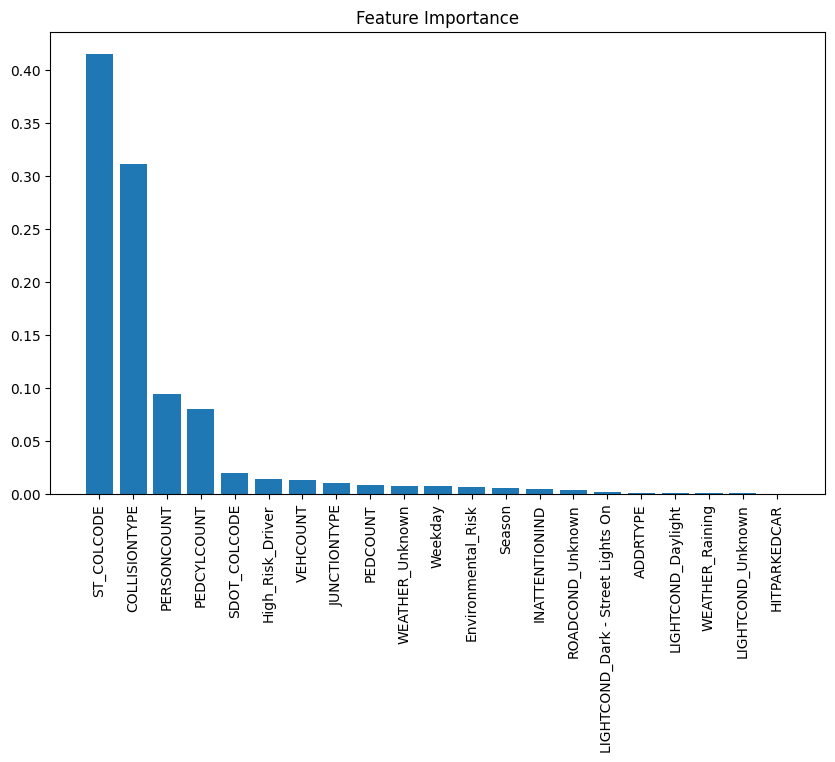

In [ ]:
# Feature Importance (Random Forest Built-in)
importances = dt_classifier.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

# Bar Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.show()

In [ ]:
graph = graphviz.Source.from_file('tree.dot')
graph.view()

'tree.dot.pdf'

In [15]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Set up the parameter space for Bayesian Optimization
param_space = {
    'n_estimators': (50, 500),  # Number of trees in the forest
    'max_depth': (10, 20),   # Maximum depth of the tree
    'max_features': (5, 10)  # Number of features to consider for the best split
}

# Perform Bayesian Optimization using `BayesSearchCV`
optimizer = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations
    cv=3,       # Number of cross-validation folds
    scoring='accuracy'  # You can use 'accuracy', 'f1', or 'roc_auc' as metrics
)

# Fit the optimizer on the training data
optimizer.fit(X_train, y_train)

# Get the best parameters
best_params = optimizer.best_params_
score = optimizer.score
print("Best parameters found:", best_params)
print("Best score:", score)

c:\Users\Initi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KeyboardInterrupt: 

Random Forest Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model with the best hyperparameters
rf = RandomForestClassifier(max_depth=14, max_features=7, n_estimators=175, min_samples_split=1000, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=7,
                       min_samples_split=1000, n_estimators=175,
                       random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Perform Cross-Validation
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Accuracy: 0.5845653939886272

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.60      0.71     12520
           1       0.43      0.55      0.48      5613
           2       0.07      0.61      0.13       332

    accuracy                           0.58     18465
   macro avg       0.46      0.59      0.44     18465
weighted avg       0.73      0.58      0.63     18465

Confusion Matrix:
 [[7481 4025 1014]
 [ 949 3112 1552]
 [  33   98  201]]

Cross-Validation Scores: [0.60145143 0.60183054 0.57040728 0.57243826 0.54419411]
Mean CV Accuracy: 0.5780643236461572


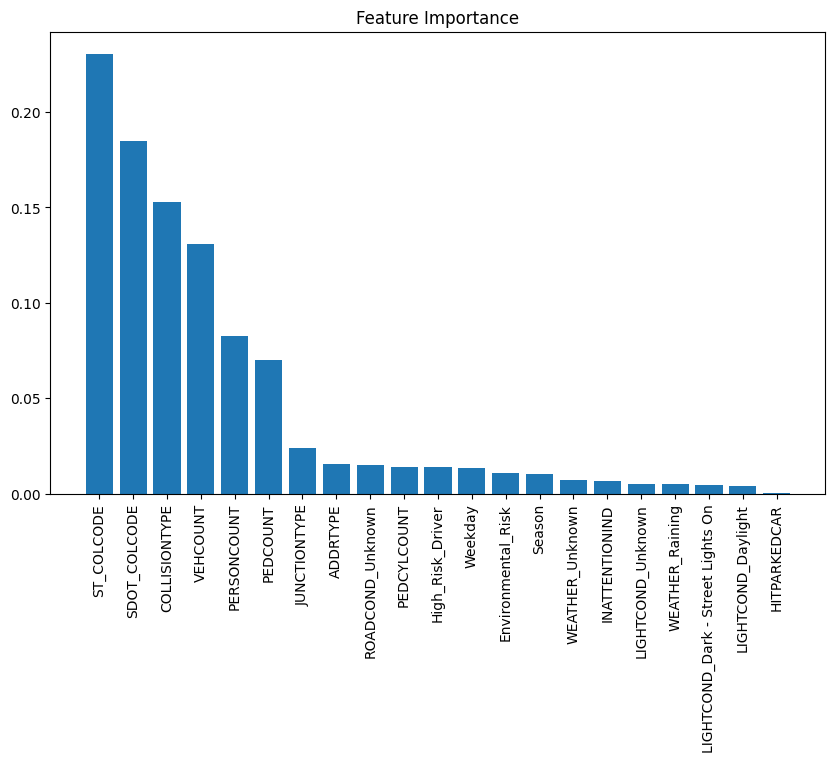

In [ ]:
import matplotlib.pyplot as plt

# Feature Importance (Random Forest Built-in)
importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

# Bar Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.show()

Gradient Boosting Model

In [ ]:


# Gradient Boosting
gb_model = GradientBoostingClassifier(max_depth=5, learning_rate=0.05, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

print("\nGradient Boosting Model:")
print("Accuracy:", accuracy_score(y_test, gb_model.predict(X_test)))
print(classification_report(y_test, gb_model.predict(X_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, gb_model.predict(X_test)))

# Perform Cross-Validation
cv_scores = cross_val_score(gb_model, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Gradient Boosting Model:
Accuracy: 0.7413484971567831
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     12520
           1       0.67      0.35      0.46      5613
           2       0.50      0.00      0.01       332

    accuracy                           0.74     18465
   macro avg       0.64      0.43      0.43     18465
weighted avg       0.72      0.74      0.71     18465

Confusion Matrix:
 [[11748   772     0]
 [ 3672  1940     1]
 [  135   196     1]]

Cross-Validation Scores: [0.73086192 0.74302039 0.74588388 0.73992634 0.73822032]
Mean CV Accuracy: 0.7395825721278448


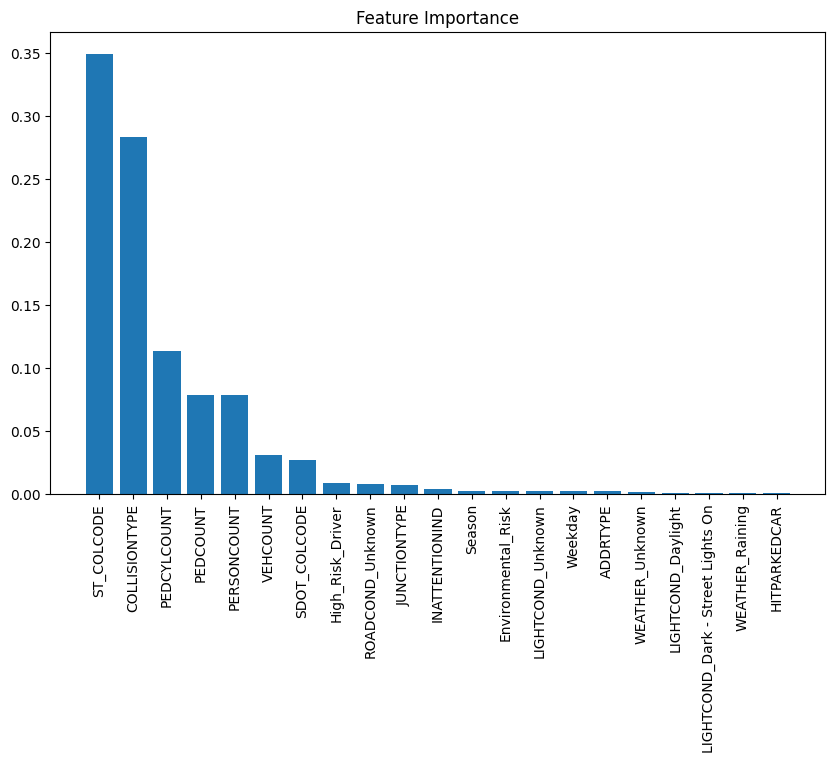

In [ ]:
# Feature Importance (Random Forest Built-in)
importances = gb_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

# Bar Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.show()